In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

from sklearn.model_selection import cross_val_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor, StackingRegressor

import pickle
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
import os
import joblib
import time

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Removing big RMSE Outliers for XGBoost preds
    # do same for test
# xg_rmse_errors = pd.concat([pd.DataFrame(y_train),fe_rmse_train_df['XGBoost']], axis = 1)
# xg_rmse_errors['diff'] = (xg_rmse_errors['price']-xg_rmse_errors['XGBoost'])**2
# pd.set_option('display.float_format', str)
# round(xg_rmse_errors.sort_values('diff', ascending = False),1)[:50].index

# [10271, 19489, 16028, 18610, 20745,  3592,  4149,  7292, 13552,
#             10662, 11115, 20129, 18007, 17038, 15799,   466,  3502, 10827,
#             10633,  9239,  6244, 14765, 20383, 20489, 20228,  8941,  5472,
#             11993,  7628, 10485, 13858,  4482, 18650,  6679, 13271, 14772,
#             12982, 17795,  4770, 13673,  8570, 14850, 14913,  9387, 13311,
#              5222, 20037, 10549, 14553,   187]

In [3]:
fe_df = pd.read_excel('/kaggle/input/latest-data/fe_data_v2.xlsx')
df1 = fe_df.sample(n = 10000, random_state = 1998)
outliers = [13719,  9335, 16647, 16375,    98,  1740,  2668, 15960, 12034,
            17020,  9429, 15371, 12127,  6897,  7071, 17977,  8014,  2572,
             2108, 13536,  7726, 11284,  3978, 14630, 19750, 15172, 10177,
             1393,  7903,  2140, 10271, 19489, 16028, 18610, 20745,  3592,  4149,  7292, 13552,
            10662, 11115, 20129, 18007, 17038, 15799,   466,  3502, 10827,
            10633,  9239,  6244, 14765, 20383, 20489, 20228,  8941,  5472,
            11993,  7628, 10485, 13858,  4482, 18650,  6679, 13271, 14772,
            12982, 17795,  4770, 13673,  8570, 14850, 14913,  9387, 13311,
             5222, 20037, 10549, 14553,   187, 19398,  1114, 17542, 19520, 18362, 14888, 15367,  2851, 14322,
             5607, 18752,   191,  9440,  7864, 17272, 11992, 14592, 10878,
             6705, 16030, 20219, 20459, 14679, 16412, 16633, 12280,  9417,
            19725,  8091, 18940, 20397,  3335,  9847, 20778, 10927, 18188,
            11802,   902, 18233, 20814,  5960, 12839,   153, 10743, 15504,
             1657,  1135, 12011,  1015, 14965]
df1.drop(index=outliers, inplace = True)

fe_x = df1.drop(columns = 'price').copy()
fe_y = df1['price'].copy()

np.set_printoptions(formatter={'float_kind':'{:f}'.format})

X_train, X_test, y_train, y_test = train_test_split(fe_x.fillna(0), fe_y, test_size=0.2, random_state=42)
X_train.drop(columns = 'Unnamed: 0', inplace=True)
X_test.drop(columns = 'Unnamed: 0', inplace=True)
print("FE Data")
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

## Now for Raw dataset
default_df = pd.read_excel('/kaggle/input/latest-data/default_df_v2.xlsx')
# get only those that are in FE set
df2 = default_df[default_df.index.isin(df1.index)]
default_x = df2[df2.index.isin(fe_x.index)].drop(columns = 'price').fillna(0).copy()
default_y = df2[df2.index.isin(fe_x.index)]['price'].copy()

X_train_raw = default_x[default_x.index.isin(X_train.index)]
X_test_raw = default_x[default_x.index.isin(X_test.index)]
y_train_raw = default_y[default_y.index.isin(y_train.index)]
y_test_raw = default_y[default_y.index.isin(y_test.index)]

X_train_raw.drop(columns = 'Unnamed: 0', inplace=True)
X_test_raw.drop(columns = 'Unnamed: 0', inplace=True)
print("Raw Data")
print(X_train_raw.shape, X_test_raw.shape)
print(y_train_raw.shape, y_test_raw.shape)

FE Data
(7896, 149) (1974, 149)
(7896,) (1974,)
Raw Data
(7896, 92) (1974, 92)
(7896,) (1974,)


# CV Results of final dataset

In [4]:
loaded_models = {}
loaded_models['Linear Regression'] = joblib.load('/kaggle/input/final-models/linreg1.pkl')
loaded_models['Lasso'] = joblib.load('/kaggle/input/final-models/lasso1.pkl')
loaded_models['Ridge'] = joblib.load('/kaggle/input/final-models/ridge1.pkl')
loaded_models['Elastic Net'] = joblib.load('/kaggle/input/final-models/elasticnet1.pkl')
loaded_models['KNN'] = joblib.load('/kaggle/input/final-models/knn1.pkl')
loaded_models['SVR'] = joblib.load('/kaggle/input/final-models/svr1.pkl')
loaded_models['Decision Tree'] = joblib.load('/kaggle/input/final-models/dt1.pkl')
loaded_models['Random Forest'] = joblib.load('/kaggle/input/final-models/rf1.pkl')
loaded_models['XGBoost'] = joblib.load('/kaggle/input/final-models/xgb1.pkl')
loaded_models['GBM'] = joblib.load('/kaggle/input/final-models/gbm1.pkl')
loaded_models['MLP'] = joblib.load('/kaggle/input/final-models/mlp1.pkl')

loaded_models['Stack All'] = joblib.load('/kaggle/input/final-models/stack_lr_all.pkl')
loaded_models['Stack Top 5'] = joblib.load('/kaggle/input/final-models/stack_top_5.pkl')
loaded_models['Voting All'] = joblib.load('/kaggle/input/final-models/voting_all.pkl')
loaded_models['Voting Top 5'] = joblib.load('/kaggle/input/final-models/voting_top_5.pkl')

[13:16:44] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[13:16:44] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[13:16:45] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, pl

In [5]:
model_names = []
train_mae = []
train_mse = []
train_rmse = []
train_r2 = []
test_mae = []
test_mse = []
test_rmse = []
test_r2 = []
all_st_time = time.time()
for i in loaded_models.items():
    model_names.append(i[0])
    train_preds = i[1].predict(X_train)
    test_preds = i[1].predict(X_test)

    train_mae.append(mean_absolute_error(y_train, train_preds))
    train_mse.append(mean_squared_error(y_train, train_preds))
    train_rmse.append(math.sqrt(mean_squared_error(y_train, train_preds)))
    train_r2.append(r2_score(y_train, train_preds))
    test_mae.append(mean_absolute_error(y_test, test_preds))
    test_mse.append(mean_squared_error(y_test, test_preds))
    test_rmse.append(math.sqrt(mean_squared_error(y_test, test_preds)))
    test_r2.append(r2_score(y_test, test_preds))
    print(f'{i[0]} scored.')

all_fn_time = time.time()    
elapsed_time = all_st_time - all_fn_time
print('Execution time:', elapsed_time, 'seconds')

single_df = pd.DataFrame({
    'Model':model_names,
    'Train MAE':train_mae,
    'Train MSE':train_mse,
    'Train RMSE':train_rmse,
    'Train R2':train_r2,
    'Test MAE':test_mae,
    'Test MSE':test_mse,
    'Test RMSE':test_rmse,
    'Test R2':test_r2
})
single_df = single_df.round(2)

Linear Regression scored.
Lasso scored.
Ridge scored.
Elastic Net scored.
KNN scored.
SVR scored.
Decision Tree scored.
Random Forest scored.
XGBoost scored.
GBM scored.
MLP scored.
Stack All scored.
Stack Top 5 scored.
Voting All scored.
Voting Top 5 scored.
Execution time: -141.64685201644897 seconds


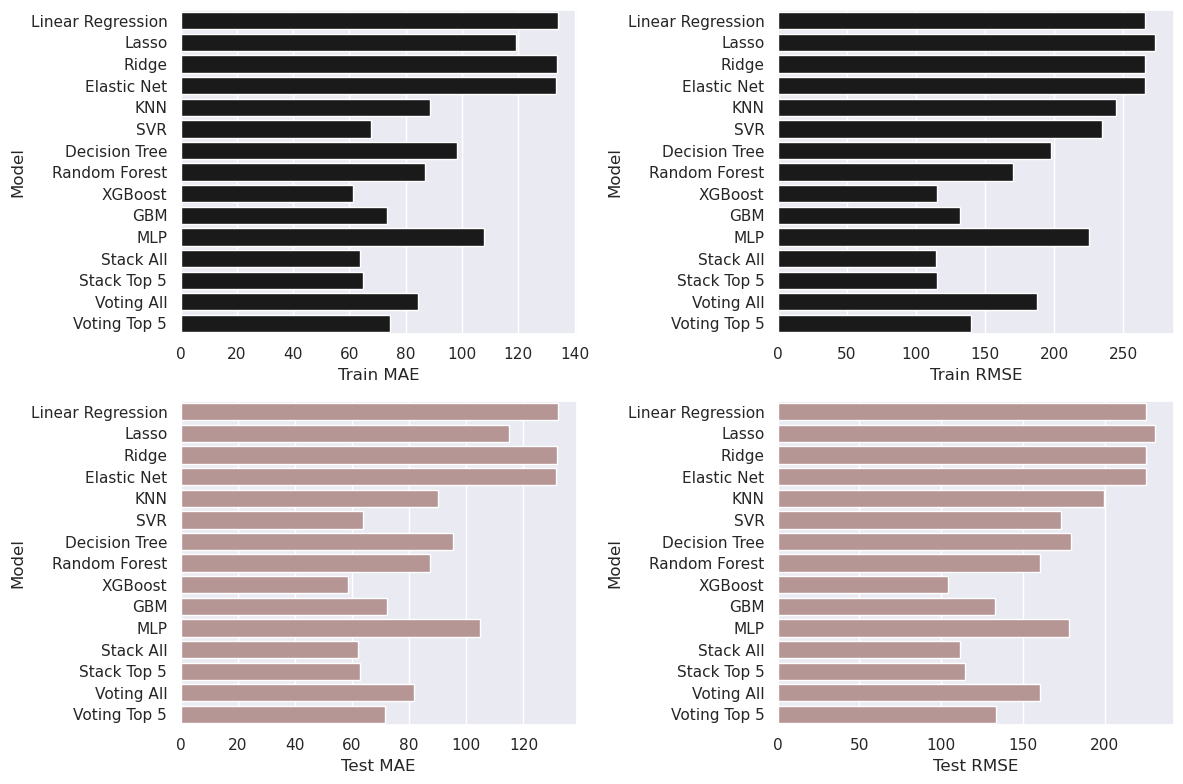

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

sns.barplot(data=single_df, y = 'Model', x = 'Train MAE', color= 'k', dodge=False, ax=axes[0])
sns.barplot(data=single_df, y = 'Model', x = 'Train RMSE', color= 'k', dodge=False, ax=axes[1])
sns.barplot(data=single_df, y = 'Model', x = 'Test MAE', color= 'rosybrown', dodge=False, ax=axes[2])
sns.barplot(data=single_df, y = 'Model', x = 'Test RMSE', color= 'rosybrown', dodge=False, ax=axes[3])
# palette = dark:salmon_r or crest

# for i in range(4):
#     axes[i].get_legend().remove()
fig.tight_layout()
plt.show()

# CV Results of raw dataset

In [7]:
raw_models = {}
raw_models['Linear Regression'] = joblib.load('/kaggle/input/raw-models/linreg1.pkl')
raw_models['Lasso'] = joblib.load('/kaggle/input/raw-models/lasso1.pkl')
raw_models['Ridge'] = joblib.load('/kaggle/input/raw-models/ridge1.pkl')
raw_models['Elastic Net'] = joblib.load('/kaggle/input/raw-models/elasticnet1.pkl')
raw_models['KNN'] = joblib.load('/kaggle/input/raw-models/knn1.pkl')
raw_models['SVR'] = joblib.load('/kaggle/input/raw-models/svr1.pkl')
raw_models['Decision Tree'] = joblib.load('/kaggle/input/raw-models/dt1.pkl')
raw_models['Random Forest'] = joblib.load('/kaggle/input/raw-models/rf1.pkl')
raw_models['XGBoost'] = joblib.load('/kaggle/input/raw-models/xgb1.pkl')
raw_models['GBM'] = joblib.load('/kaggle/input/raw-models/gbm1.pkl')
raw_models['MLP'] = joblib.load('/kaggle/input/raw-models/mlp1.pkl')

raw_models['Stack All'] = joblib.load('/kaggle/input/raw-models/stack_lr_all.pkl')
raw_models['Stack Top 5'] = joblib.load('/kaggle/input/raw-models/stack_top_5.pkl')
raw_models['Voting All'] = joblib.load('/kaggle/input/raw-models/voting_all.pkl')
raw_models['Voting Top 5'] = joblib.load('/kaggle/input/raw-models/voting_top_5.pkl')

[13:19:16] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[13:19:16] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[13:19:17] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, pl

In [8]:
model_names = []
train_mae = []
train_mse = []
train_rmse = []
train_r2 = []
test_mae = []
test_mse = []
test_rmse = []
test_r2 = []
all_st_time = time.time()
for i in raw_models.items():
    model_names.append(i[0])
    train_preds = i[1].predict(X_train_raw)
    test_preds = i[1].predict(X_test_raw)

    train_mae.append(mean_absolute_error(y_train_raw, train_preds))
    train_mse.append(mean_squared_error(y_train_raw, train_preds))
    train_rmse.append(math.sqrt(mean_squared_error(y_train_raw, train_preds)))
    train_r2.append(r2_score(y_train_raw, train_preds))
    test_mae.append(mean_absolute_error(y_test_raw, test_preds))
    test_mse.append(mean_squared_error(y_test_raw, test_preds))
    test_rmse.append(math.sqrt(mean_squared_error(y_test_raw, test_preds)))
    test_r2.append(r2_score(y_test_raw, test_preds))
    print(f'{i[0]} scored.')

all_fn_time = time.time()    
elapsed_time = all_st_time - all_fn_time
print('Execution time:', elapsed_time, 'seconds')

raw_df = pd.DataFrame({
    'Model':model_names,
    'Train MAE':train_mae,
    'Train MSE':train_mse,
    'Train RMSE':train_rmse,
    'Train R2':train_r2,
    'Test MAE':test_mae,
    'Test MSE':test_mse,
    'Test RMSE':test_rmse,
    'Test R2':test_r2
})
raw_df = raw_df.round(2)

Linear Regression scored.
Lasso scored.
Ridge scored.
Elastic Net scored.
KNN scored.
SVR scored.
Decision Tree scored.
Random Forest scored.
XGBoost scored.
GBM scored.
MLP scored.
Stack All scored.
Stack Top 5 scored.
Voting All scored.
Voting Top 5 scored.
Execution time: -78.65477681159973 seconds


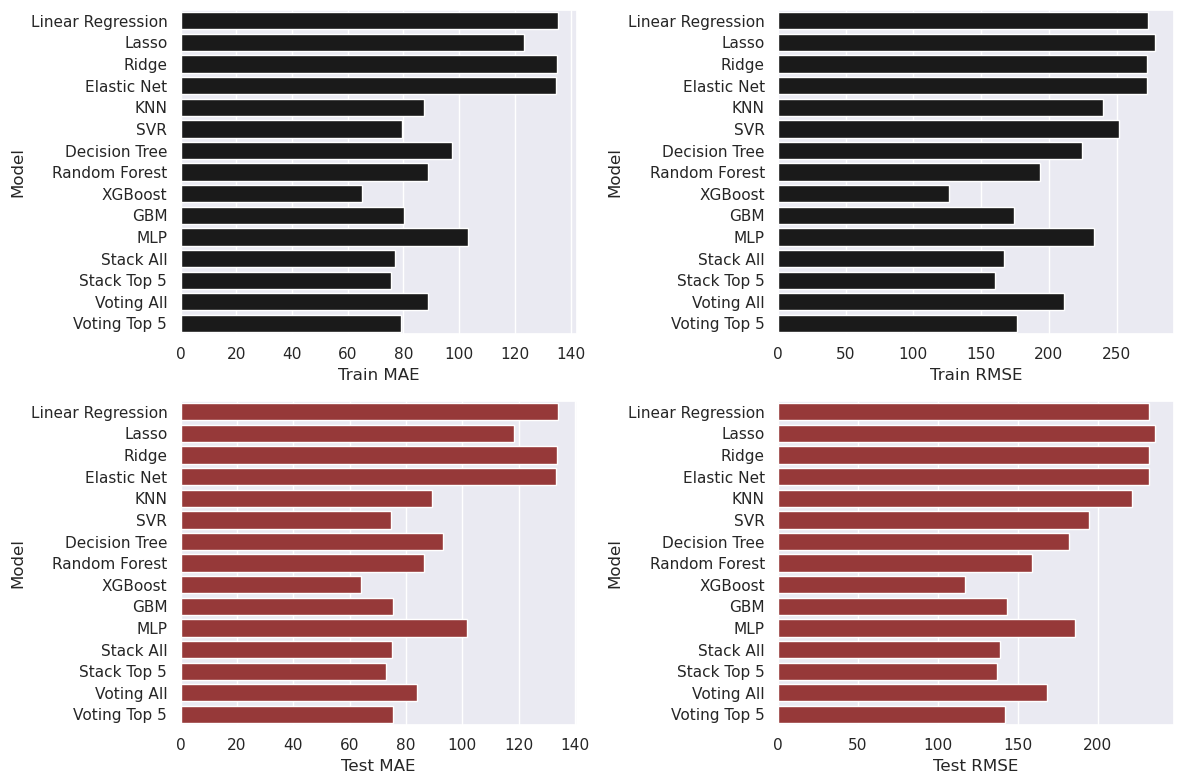

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

sns.barplot(data=raw_df, y = 'Model', x = 'Train MAE', color= 'k', dodge=False, ax=axes[0])
sns.barplot(data=raw_df, y = 'Model', x = 'Train RMSE', color= 'k', dodge=False, ax=axes[1])
sns.barplot(data=raw_df, y = 'Model', x = 'Test MAE', color= 'brown', dodge=False, ax=axes[2])
sns.barplot(data=raw_df, y = 'Model', x = 'Test RMSE', color= 'brown', dodge=False, ax=axes[3])
# palette = dark:salmon_r or crest

# for i in range(4):
#     axes[i].get_legend().remove()
fig.tight_layout()
plt.show()

In [10]:
raw_df

,Model,Train MAE,Train MSE,Train RMSE,Train R2,Test MAE,Test MSE,Test RMSE,Test R2
0,Linear Regression,135.30,74472.53,272.90,0.43,133.85,54053.14,232.49,0.52
1,Lasso,123.11,77562.43,278.50,0.40,118.51,55716.89,236.04,0.51
2,Ridge,134.92,74442.67,272.84,0.43,133.50,54006.88,232.39,0.52
3,Elastic Net,134.71,74435.60,272.83,0.43,133.24,53969.85,232.31,0.52
4,KNN,87.34,57599.19,240.00,0.56,89.17,49058.27,221.49,0.57
5,SVR,79.30,63320.48,251.64,0.51,74.76,37913.34,194.71,0.66
6,Decision Tree,97.51,50545.73,224.82,0.61,93.00,33200.67,182.21,0.71
7,Random Forest,88.65,37356.92,193.28,0.71,86.54,25367.33,159.27,0.78
8,XGBoost,65.01,15965.91,126.36,0.88,63.91,13755.67,117.28,0.88
9,GBM,80.07,30430.17,174.44,0.77,75.36,20602.49,143.54,0.82


In [11]:
single_df

,Model,Train MAE,Train MSE,Train RMSE,Train R2,Test MAE,Test MSE,Test RMSE,Test R2
0,Linear Regression,134.10,70538.42,265.59,0.46,132.08,50828.31,225.45,0.55
1,Lasso,119.30,74458.60,272.87,0.43,114.78,53267.49,230.80,0.53
2,Ridge,133.71,70510.27,265.54,0.46,131.62,50671.62,225.10,0.55
3,Elastic Net,133.47,70497.10,265.51,0.46,131.34,50598.52,224.94,0.55
4,KNN,88.54,59988.51,244.93,0.54,90.08,39753.42,199.38,0.65
5,SVR,67.76,55051.62,234.63,0.58,63.93,30065.70,173.39,0.73
6,Decision Tree,98.11,39162.67,197.90,0.70,95.26,32165.28,179.35,0.72
7,Random Forest,86.81,29059.30,170.47,0.78,87.25,25811.69,160.66,0.77
8,XGBoost,61.40,13347.16,115.53,0.90,58.52,10860.66,104.21,0.90
9,GBM,73.44,17454.79,132.12,0.87,72.12,17683.87,132.98,0.84


# Model Confidence Set

Take the loss for every example in the dataset. `y-y_hat ** 2` for RMSE, `y-y_hat` for MAE. Should have a df of losses, each column represents a model. This will be used as input for MCS. 

In [12]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 17.0 MB/s eta 0:00:0000:01


In [13]:
from arch.bootstrap import MCS

In [14]:
fe_mae_train_df = {}
fe_mae_test_df = {}
fe_rmse_train_df = {}
fe_rmse_test_df = {}

all_st_time = time.time()
for i in loaded_models.items():
    train_preds = i[1].predict(X_train)
    test_preds = i[1].predict(X_test)
    
    fe_mae_train_df[i[0]] = abs(y_train - train_preds)
    fe_mae_test_df[i[0]] = abs(y_test - test_preds)
    fe_rmse_train_df[i[0]] = (y_train - train_preds)**2
    fe_rmse_test_df[i[0]] = (y_test - test_preds)**2
    
    print(f'{i[0]} scored.')

all_fn_time = time.time()    
elapsed_time = all_st_time - all_fn_time
print('Execution time:', elapsed_time, 'seconds')

fe_mae_train_df = pd.DataFrame(fe_mae_train_df)
fe_mae_test_df = pd.DataFrame(fe_mae_test_df)
fe_rmse_train_df = pd.DataFrame(fe_rmse_train_df)
fe_rmse_test_df = pd.DataFrame(fe_rmse_test_df)

Linear Regression scored.
Lasso scored.
Ridge scored.
Elastic Net scored.
KNN scored.
SVR scored.
Decision Tree scored.
Random Forest scored.
XGBoost scored.
GBM scored.
MLP scored.
Stack All scored.
Stack Top 5 scored.
Voting All scored.
Voting Top 5 scored.
Execution time: -145.08344411849976 seconds


In [15]:
mcs_MAE_train = MCS(fe_mae_train_df, size = 0.10)
mcs_MAE_train.compute()
mcs_MAE_test = MCS(fe_mae_test_df, size = 0.10)
mcs_MAE_test.compute()
mcs_RMSE_train = MCS(fe_rmse_train_df, size = 0.10)
mcs_RMSE_train.compute()
mcs_RMSE_test = MCS(fe_rmse_test_df, size = 0.10)
mcs_RMSE_test.compute()
print("MCS p-values MAE Train")
print(mcs_MAE_train.pvalues)
print("Included")
print(mcs_MAE_train.included)

print("MCS p-values MAE Test")
print(mcs_MAE_test.pvalues)
print("Included")
print(mcs_MAE_test.included)

print("MCS p-values RMSE Train")
print(mcs_RMSE_train.pvalues)
print("Included")
print(mcs_RMSE_train.included)

print("MCS p-values RMSE Test")
print(mcs_RMSE_test.pvalues)
print("Included")
print(mcs_RMSE_test.included)

MCS p-values MAE Train
                   Pvalue
Model name               
Elastic Net         0.000
Ridge               0.000
Linear Regression   0.000
Lasso               0.000
MLP                 0.000
Random Forest       0.000
Decision Tree       0.000
GBM                 0.000
Voting All          0.000
Voting Top 5        0.000
KNN                 0.000
Stack Top 5         0.000
Stack All           0.001
SVR                 0.011
XGBoost             1.000
Included
['XGBoost']
MCS p-values MAE Test
                   Pvalue
Model name               
Linear Regression   0.000
Ridge               0.000
Elastic Net         0.000
Lasso               0.000
MLP                 0.000
Random Forest       0.000
Decision Tree       0.000
Voting All          0.000
GBM                 0.000
Voting Top 5        0.000
KNN                 0.000
Stack Top 5         0.000
Stack All           0.000
SVR                 0.061
XGBoost             1.000
Included
['XGBoost']
MCS p-values RMSE Train
     

In [16]:
raw_mae_train_df = {}
raw_mae_test_df = {}
raw_rmse_train_df = {}
raw_rmse_test_df = {}

all_st_time = time.time()
for i in raw_models.items():
    raw_train_preds = i[1].predict(X_train_raw)
    raw_test_preds = i[1].predict(X_test_raw)
    
    raw_mae_train_df[i[0]] = abs(y_train_raw - raw_train_preds)
    raw_mae_test_df[i[0]] = abs(y_test_raw - raw_test_preds)
    raw_rmse_train_df[i[0]] = (y_train_raw - raw_train_preds)**2
    raw_rmse_test_df[i[0]] = (y_test_raw - raw_test_preds)**2
    
    print(f'{i[0]} scored.')

all_fn_time = time.time()    
elapsed_time = all_st_time - all_fn_time
print('Execution time:', elapsed_time, 'seconds')

raw_mae_train_df = pd.DataFrame(raw_mae_train_df)
raw_mae_test_df = pd.DataFrame(raw_mae_test_df)
raw_rmse_train_df = pd.DataFrame(raw_rmse_train_df)
raw_rmse_test_df = pd.DataFrame(raw_rmse_test_df)

Linear Regression scored.
Lasso scored.
Ridge scored.
Elastic Net scored.
KNN scored.
SVR scored.
Decision Tree scored.
Random Forest scored.
XGBoost scored.
GBM scored.
MLP scored.
Stack All scored.
Stack Top 5 scored.
Voting All scored.
Voting Top 5 scored.
Execution time: -78.53666567802429 seconds


In [17]:
raw_mcs_MAE_train = MCS(raw_mae_train_df, size = 0.10)
raw_mcs_MAE_train.compute()
raw_mcs_MAE_test = MCS(raw_mae_test_df, size = 0.10)
raw_mcs_MAE_test.compute()
raw_mcs_RMSE_train = MCS(raw_rmse_train_df, size = 0.10)
raw_mcs_RMSE_train.compute()
raw_mcs_RMSE_test = MCS(raw_rmse_test_df, size = 0.10)
raw_mcs_RMSE_test.compute()
print("MCS p-values MAE Train")
print(raw_mcs_MAE_train.pvalues)
print("Included")
print(raw_mcs_MAE_train.included)

print("MCS p-values MAE Test")
print(raw_mcs_MAE_test.pvalues)
print("Included")
print(raw_mcs_MAE_test.included)

print("MCS p-values RMSE Train")
print(raw_mcs_RMSE_train.pvalues)
print("Included")
print(raw_mcs_RMSE_train.included)

print("MCS p-values RMSE Test")
print(raw_mcs_RMSE_test.pvalues)
print("Included")
print(raw_mcs_RMSE_test.included)

MCS p-values MAE Train
                   Pvalue
Model name               
Linear Regression     0.0
Elastic Net           0.0
Ridge                 0.0
Lasso                 0.0
MLP                   0.0
Random Forest         0.0
Decision Tree         0.0
Voting All            0.0
GBM                   0.0
Voting Top 5          0.0
Stack Top 5           0.0
Stack All             0.0
KNN                   0.0
SVR                   0.0
XGBoost               1.0
Included
['XGBoost']
MCS p-values MAE Test
                   Pvalue
Model name               
Ridge                 0.0
Elastic Net           0.0
Linear Regression     0.0
Lasso                 0.0
Random Forest         0.0
MLP                   0.0
Decision Tree         0.0
Voting All            0.0
GBM                   0.0
Voting Top 5          0.0
Stack All             0.0
Stack Top 5           0.0
KNN                   0.0
SVR                   0.0
XGBoost               1.0
Included
['XGBoost']
MCS p-values RMSE Train
     

### MCS for FE vs Non FE (RAW) datasets

In [18]:
mae_train_concat_df = pd.concat([fe_mae_train_df.add_prefix("FE "), raw_mae_train_df.add_prefix("RAW ")], axis=1)
mae_test_concat_df = pd.concat([fe_mae_test_df.add_prefix("FE "), raw_mae_test_df.add_prefix("RAW ")], axis=1)
rmse_train_concat_df = pd.concat([fe_rmse_train_df.add_prefix("FE "), raw_rmse_train_df.add_prefix("RAW ")], axis=1)
rmse_test_concat_df = pd.concat([fe_rmse_test_df.add_prefix("FE "), raw_rmse_test_df.add_prefix("RAW ")], axis=1)
print(mae_train_concat_df.shape, mae_test_concat_df.shape, rmse_train_concat_df.shape, rmse_test_concat_df.shape)

(7896, 30) (1974, 30) (7896, 30) (1974, 30)


In [19]:
mcs_MAE_train = MCS(mae_train_concat_df, size = 0.10)
mcs_MAE_train.compute()
print("\nMCS p-values MAE Train")
print(mcs_MAE_train.pvalues)
print("Included")
print(mcs_MAE_train.included)

mcs_MAE_test = MCS(mae_test_concat_df, size = 0.10)
mcs_MAE_test.compute()
print("\nMCS p-values MAE Test")
print(mcs_MAE_test.pvalues)
print("Included")
print(mcs_MAE_test.included)

mcs_RMSE_train = MCS(rmse_train_concat_df, size = 0.10)
mcs_RMSE_train.compute()
print("\nMCS p-values RMSE Train")
print(mcs_RMSE_train.pvalues)
print("Included")
print(mcs_RMSE_train.included)

mcs_RMSE_test = MCS(rmse_test_concat_df, size = 0.10)
mcs_RMSE_test.compute()
print("\nMCS p-values RMSE Test")
print(mcs_RMSE_test.pvalues)
print("Included")
print(mcs_RMSE_test.included)


MCS p-values MAE Train
                       Pvalue
Model name                   
FE Elastic Net          0.000
FE Ridge                0.000
FE Linear Regression    0.000
RAW Elastic Net         0.000
RAW Ridge               0.000
RAW Linear Regression   0.000
FE Lasso                0.000
RAW Lasso               0.000
FE MLP                  0.000
RAW MLP                 0.000
RAW Voting All          0.000
RAW SVR                 0.000
FE Random Forest        0.000
RAW Random Forest       0.000
FE Decision Tree        0.000
RAW Decision Tree       0.000
FE GBM                  0.000
FE Voting All           0.000
RAW GBM                 0.000
FE Voting Top 5         0.000
RAW KNN                 0.000
RAW Stack All           0.000
FE KNN                  0.000
RAW Voting Top 5        0.000
RAW Stack Top 5         0.000
FE Stack Top 5          0.000
RAW XGBoost             0.000
FE Stack All            0.004
FE SVR                  0.013
FE XGBoost              1.000
Included
['FE XG

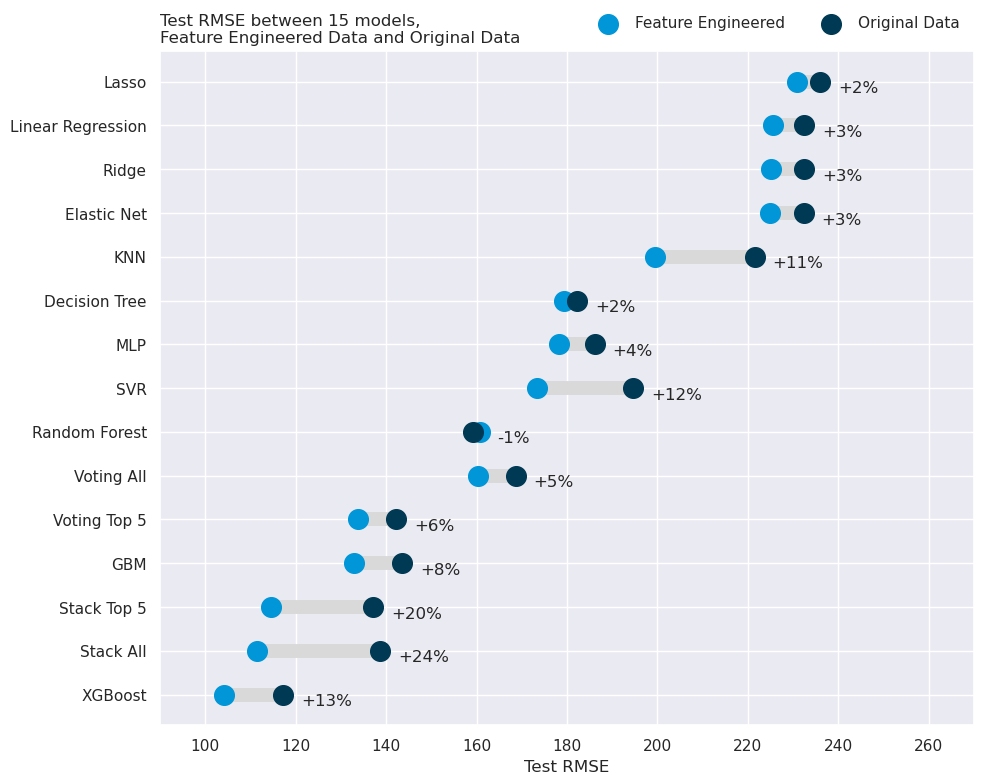

In [27]:
df = pd.concat([
           pd.DataFrame(raw_df.set_index('Model')['Test RMSE']).rename(columns = {'Test RMSE': 'Raw Test RMSE'}), 
           pd.DataFrame(single_df.set_index('Model')['Test RMSE']).rename(columns = {'Test RMSE': 'FE Test RMSE'})
          ], axis = 1).sort_values('FE Test RMSE')
df["change"] = df["Raw Test RMSE"] / df["FE Test RMSE"] - 1


plt.figure(figsize=(10,8))
y_range = np.arange(1, len(df.index) + 1)
colors = np.where(df['Raw Test RMSE'] > df['FE Test RMSE'], '#d9d9d9', '#d57883')
plt.hlines(y=y_range, xmin=df['FE Test RMSE'], xmax=df['Raw Test RMSE'],
           color=colors, lw=10)
plt.scatter(df['FE Test RMSE'], y_range, color='#0096d7', s=200, label='Feature Engineered', zorder=3)
plt.scatter(df['Raw Test RMSE'], y_range, color='#003953', s=200 , label='Original Data', zorder=3)
for (_, row), y in zip(df.iterrows(), y_range):
    plt.annotate(f"{row['change']:+.0%}", (max(row["FE Test RMSE"], row["Raw Test RMSE"]) + 4, y - 0.25))
plt.legend(ncol=2, bbox_to_anchor=(1., 1.01), loc="lower right", frameon=False)

plt.yticks(y_range, df.index)
plt.title("Test RMSE between 15 models,\nFeature Engineered Data and Original Data", loc='left')
plt.xlim(90, 270)
plt.xlabel('Test RMSE')
plt.gcf().subplots_adjust(left=0.35)
plt.tight_layout()
plt.show()

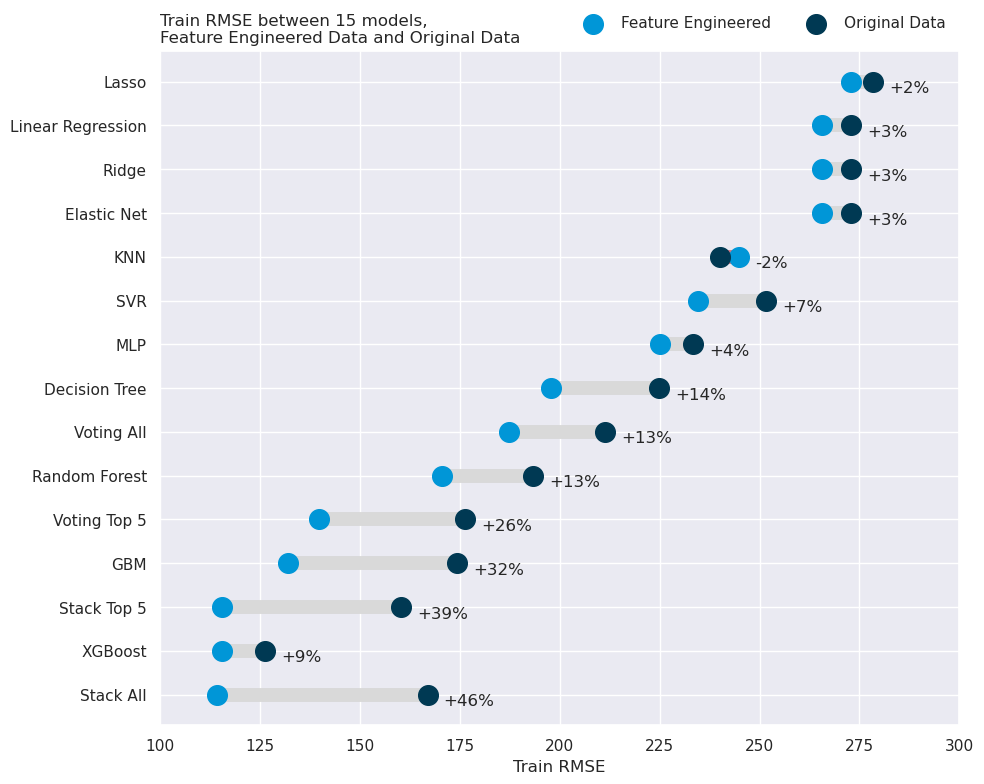

In [26]:
df = pd.concat([
           pd.DataFrame(raw_df.set_index('Model')['Train RMSE']).rename(columns = {'Train RMSE': 'Raw Train RMSE'}), 
           pd.DataFrame(single_df.set_index('Model')['Train RMSE']).rename(columns = {'Train RMSE': 'FE Train RMSE'})
          ], axis = 1).sort_values('FE Train RMSE')
df["change"] = df["Raw Train RMSE"] / df["FE Train RMSE"] - 1


plt.figure(figsize=(10,8))
y_range = np.arange(1, len(df.index) + 1)
colors = np.where(df['Raw Train RMSE'] > df['FE Train RMSE'], '#d9d9d9', '#d57883')
plt.hlines(y=y_range, xmin=df['FE Train RMSE'], xmax=df['Raw Train RMSE'],
           color=colors, lw=10)
plt.scatter(df['FE Train RMSE'], y_range, color='#0096d7', s=200, label='Feature Engineered', zorder=3)
plt.scatter(df['Raw Train RMSE'], y_range, color='#003953', s=200 , label='Original Data', zorder=3)
for (_, row), y in zip(df.iterrows(), y_range):
    plt.annotate(f"{row['change']:+.0%}", (max(row["FE Train RMSE"], row["Raw Train RMSE"]) + 4, y - 0.25))
plt.legend(ncol=2, bbox_to_anchor=(1., 1.01), loc="lower right", frameon=False)

plt.yticks(y_range, df.index)
plt.title("Train RMSE between 15 models,\nFeature Engineered Data and Original Data", loc='left')
plt.xlim(100, 300)
plt.xlabel('Train RMSE')
plt.gcf().subplots_adjust(left=0.35)
plt.tight_layout()
plt.show()

In [22]:
import shap
explainer = shap.TreeExplainer(loaded_models['XGBoost'])
shap_values = explainer(X_train)

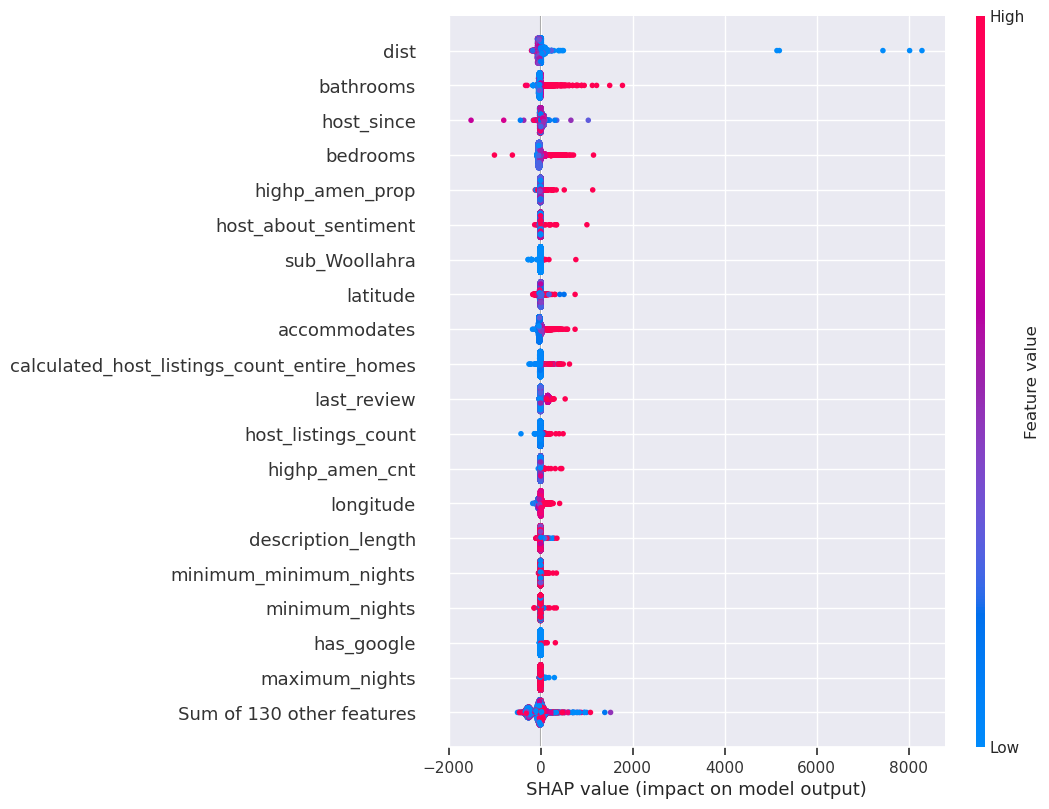

In [23]:
shap.plots.beeswarm(shap_values, max_display = 20, order=shap_values.abs.max(0))

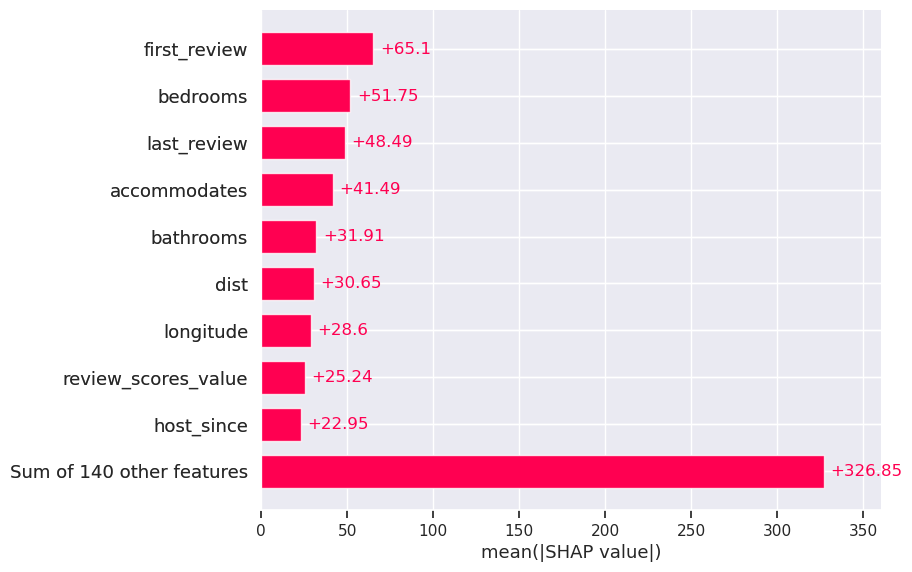

In [24]:
shap.plots.bar(shap_values)

5012     10000
12399     7800
16133     7429
15716     6000
9172      5000
Name: price, dtype: int64


Linear Regression    13.930608
Lasso                 3.815858
Ridge                14.323090
Elastic Net          14.379977
KNN                  33.000000
SVR                  20.545201
Decision Tree        29.696591
Random Forest        36.771167
XGBoost              34.259434
GBM                  50.414723
MLP                  17.332951
Stack All             7.532986
Stack Top 5          18.649324
Voting All           14.332101
Voting Top 5         13.058019
Name: 0, dtype: float64


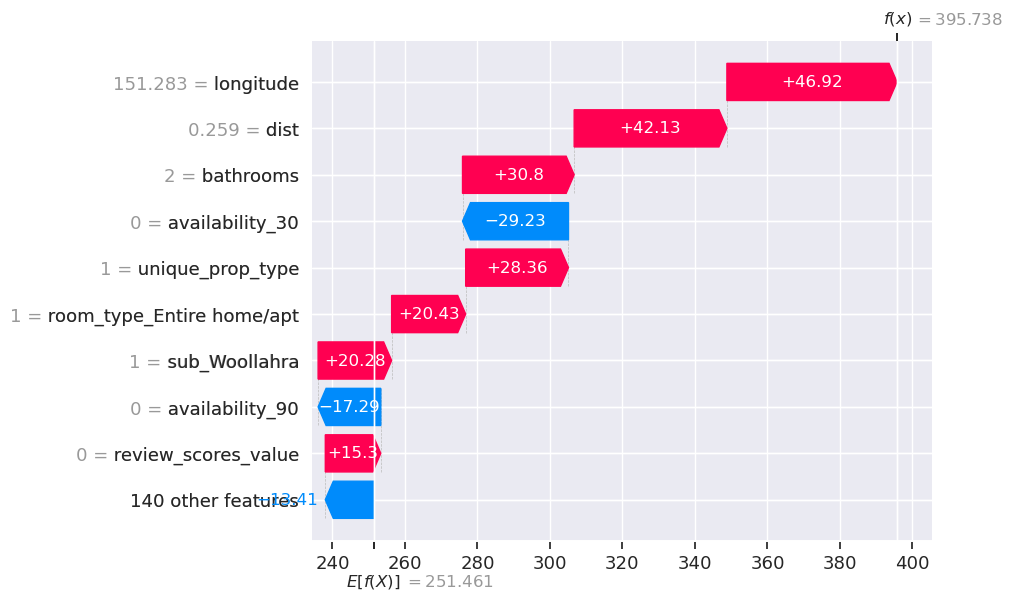

In [28]:
# predictions for the highest priced prop
    # looks to be an outlier since it has 1 bedroom, hosts 2 people, last review was years ago but is prices at almost $30k
print(y_train.sort_values(ascending=False)[:5])
print("\n")
print(fe_mae_train_df.loc[0])
shap.plots.waterfall(shap_values[0])

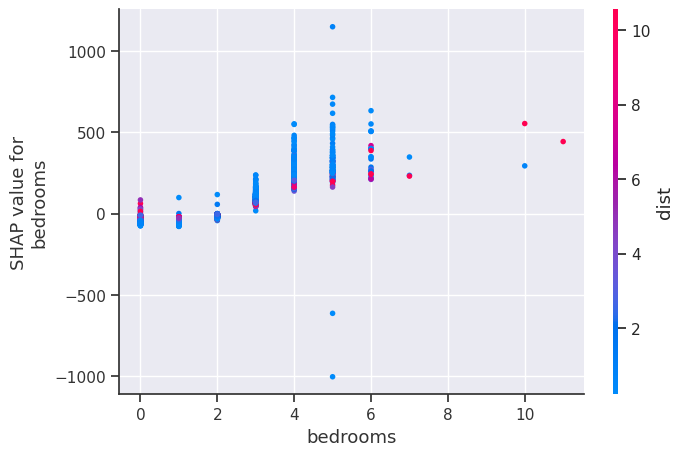

In [29]:
# automatically colors by strongest interacting feature 
    # observe that those with more bedrooms closer to the sea are higher prices
shap.dependence_plot('bedrooms', shap_values.values, X_train, feature_names = X_train.columns)